# Marchés a carnets d'ordres

## 1: Préambule

Le but de ce premier TP est d'implementer un simulateur de marché "zéro-intelligence" et d'analyser les propriétés statistiques des données générées.

In [ ]:
!pip install celluloid
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from celluloid import Camera # getting the camera
from IPython.display import HTML # to show the animation in Jupyter

## 2 : Hypotheses de modélisation

Le carnet d'ordre sera représntée par un vecteur OB de taille N. On pourra prendre N = 1000
dans l'implémentation. On fait les hypotheses suivantes :
- L'arrivée des ordres limites a chaque niveau de prix est modélisé par un processus de Poisson d'intensité $ \lambda $ .
- L'arrivée des ordres au marché est modélisée par un processus de Poisson d'intensité $ \mu $.
- L'arrivée des ordres d'annulation a chaque niveau de prix p est modélisée par un processus de Poisson d'intensité proportionnelle au nombre d'ordres a ce niveau, soit : $\delta$ *Quantité Ordres Limites au prix $p$


Tous les processus de Poisson sont indépendants.

Théoriquement, les ordres limites de vente (resp. d'achat) peuvent arriver à des prix allant de $p_{b}(t)+1$ à $\infty$ (resp. de 0 à $p_{a}(t)-1$), mais pour les besoins de l'implémentation, on ne considérera que
les arrivées et les annulations dans une fenêtre mobile de taille W allant de $p_{b}(t) + 1$ à $p_{a}(t) + W$
(resp. de $p_{b}(t) - W$ à $p_{a}(t) - 1$). On pourra prendre $W = 10$. Dans la suite du TP, on fera l'hypothèse simplifcatrice que la taille de tous les ordres est constante et égale une action.

## 3.1: Simulation du carnet d'ordre en temps événementiel.

In [ ]:
class CarnetOrdres(object):
  """
      Modèle zéro-intelligence
  """
  def __init__(self,p0= 100,tick = 0.01,N = 1000,fix_seed = None, T = 10, W = 10 , lmbda = 1 ,mu = 5 , delta = 0.2, Q = 1, OB = None):
    self.N = N
    self.p0 = p0
    self.tick = tick
    self.T = T
    self.W = W
    self.orders = orders
    self.OB = OB
    self.list_spread = list() ; self.histo_ordres = list() ;
    self.midp = list() ; self.microp = list() ; self.tradep = list() ; 
    self.Q = Q ; self.Qa = list() ; self.Qb = list() ; 
    self.a0 = self.p0 + self.tick ; self.b0 = self.p0
    self.pa = list() ; self.pb = list() ; 
    self.lmbda = lmbda ; self.mu = mu ; self.delta = delta ; 
    self.fix_seed = fix_seed
    self.carnet = pd.DataFrame()

    if self.fix_seed: 
      # On Initialise un graine pour fixer la sequence d'ordres futures au cour des t de 0 à T
      np.random.seed(fix_seed)
      self.list_seed = np.random.uniform(low=100,high=20000,size = T)

  def midprice(self):
      return (self.pa[-1]+self.pb[-1])/2

  def microprice(self):
      return ((self.Qb[-1]*self.pa[-1] + self.Qa[-1]*self.pb[-1])/(self.Qa[-1]+self.Qb[-1]))

  def spread(self):
      return self.pa[-1]-self.pb[-1]

  def probas_intervals(self,probas,orders,Na,Nb):

    normalized_prob = np.cumsum(probas)/np.sum(probas)
    iv = {} ; iv[str(orders[0])] = pd.Interval(left=0, right=normalized_prob[0])
    for i in range(1,len(normalized_prob)):
      iv[str(orders[i])] = pd.Interval(left=normalized_prob[i-1], right=normalized_prob[i])
    return iv

  def FindOrder(self,radom_val,orders,iv):
    for i in range(len(orders)):
      if radom_val in iv[str(orders[i])]:
        return orders[i]
  
  def Simulate(self):

    carnet = pd.DataFrame()
    index_ask = int(N/2) ; index_bid = int(N/2)-1  ;
    list_ind_ask = [index_ask] ; list_ind_bid = [index_bid]
    self.pa.append(self.a0) ; self.pb.append(self.b0)
    self.midp.append(self.midprice()) ; self.list_spread.append(self.spread())
    self.Qa.append(np.int(np.abs(self.OB[index_ask]))) ; self.Qb.append(np.int(np.abs(self.OB[index_bid])))
    self.microp.append(self.microprice()) ; last_transaction = self.p0
    
    for i in tqdm(range(self.T)):

      ## Calcul le nombre d ordres du cote bid et ask
      Na = np.sum(self.OB[index_ask:(index_ask + self.W)]) ; Nb = np.sum(self.OB[(index_bid - self.W):index_bid])

      probas = [self.mu/2,self.mu/2,self.W*self.lmbda,self.W*self.lmbda,self.delta*np.abs(Na),self.delta*np.abs(Nb)]
      Interv = self.probas_intervals(probas,orders,Na,Nb) ## Retourne les intervales pour chaque ordre 
      Random_Choice = np.random.uniform(low = 0, high = 1) ## v.a unif entre 0 et 1 
      new_order = self.FindOrder(Random_Choice,orders,Interv) ## Retourne l ordre choisit aleatoirement

      iloc = np.random.randint(low = 1, high = self.W) ## v.a unif entre 1 et W pour choisir a quelle niveau de prix l ordre est passé
      #print(new_order)
      self.histo_ordres.append(new_order)
      if new_order ==  "Ls" : ## Limit order a la vente
      # on prend le iloc ieme tick a droite de la meilleur offre bid 
        self.OB[index_bid + iloc] = self.OB[index_bid + iloc] + 1 
        self.tradep.append(last_transaction)

      elif new_order ==  "Lb" : ## Limit order a l'achat
      # on prend le iloc ieme tick a gauche de la meilleur offre ask
        self.OB[index_ask - iloc] = self.OB[index_ask - iloc] - 1
        self.tradep.append(last_transaction)

      elif new_order == "Cb": ## Cancel order a l'achat
      # on prend le iloc ieme tick a gauche de la meilleur offre ask
        if self.OB[index_ask - iloc] < 0 :
          self.OB[index_ask - iloc] = int(self.OB[index_ask - iloc] + delta*np.abs(self.OB[index_ask - iloc]))
          self.tradep.append(last_transaction)

      elif new_order == "Cs": ## Cancel order a la vente
      # on prend le iloc ieme tick a droite de la meilleur offre bid
        if self.OB[index_bid + iloc] > 0 :
          self.OB[index_bid + iloc] = int(self.OB[index_bid + iloc] - delta*np.abs(self.OB[index_bid + iloc]))
          self.tradep.append(last_transaction)

      elif new_order ==  "Ms" : ## Market order a la vente
      # on consomme directement la liquidité au meilleur prix ask
        self.OB[index_bid] = int(self.OB[index_bid] +1)
        self.tradep.append(self.pa[-1]) ; last_transaction = self.pa[-1]
        
      elif new_order ==  "Mb" : ## Market order a l'achat
      # on consomme directement la liquidité au meilleur prix bid
        self.OB[index_ask] = int(self.OB[index_ask] - 1)
        self.tradep.append(self.pb[-1]) ; last_transaction = self.pb[-1]
      

        
      index_ask = np.min(np.where(np.array(self.OB) > 0)[0]) ; list_ind_ask.append(index_ask) ; self.pa.append(self.pa[-1] + self.tick*(list_ind_ask[-1] - list_ind_ask[-2]));
      index_bid = np.max(np.where(np.array(self.OB) < 0)[0]) ; list_ind_bid.append(index_bid) ; self.pb.append(self.pb[-1] + self.tick*(list_ind_bid[-1] - list_ind_bid[-2]));

      
      self.Qa.append(np.abs(self.OB[index_ask])) ; self.Qb.append(np.abs(self.OB[index_bid])) ; self.list_spread.append(self.spread())
      self.midp.append(self.midprice()) ; self.microp.append(self.microprice())

      self.carnet = self.carnet.append(pd.DataFrame([self.OB]), ignore_index = True)



In [ ]:
N = 1000  # vecteur OB de taille finie N
lmbda = 1 ; mu = 5 ; delta = 0.2 ; T = 300 ; W = 10  ; Q = 1 # intensités des proc poisson et T horizon du carnet d'ordre
OB = int(N/2)*[-5] + int(N/2)*[5]  # Initialisation du vecteur OB , valeurs arbitraires
tick = 0.01 ;p0 = 100; orders = ["Ms","Mb","Lb","Ls","Cs","Cb"]

In [ ]:
## Construction d un object carnet
CarnetA = CarnetOrdres(N = N,fix_seed = None, T = T, W = W , lmbda = 1 ,mu = 5 , delta = 0.2, Q = 1, OB = OB)
CarnetA.Simulate()
Historique = CarnetA.histo_ordres
C = CarnetA.carnet.iloc[:, int(N/2-W-5):int(N/2+W+4)]
Historique = CarnetA.histo_ordres

In [ ]:
%%capture
from celluloid import Camera # getting the camera
from IPython.display import HTML # to show the animation in Jupyter

cdict = {1: 'blue', 2: 'red' , 3: "white"}
labels = ["bid","ask","spread"] 

fig, ax = plt.subplots(figsize = (15,8))
camera = Camera(fig)# the camera gets the fig we'll plot
for t in tqdm(range(0,T,1)):
  x = C.iloc[t,:].index.values# - np.array(np.repeat(N/2,len(C.mean(axis = 0).index.to_list())))
  y = C.iloc[t,:].values
  if len(np.where(np.array(y) == 0)[0]) == 0:
    cblue = np.where(np.array(y) < 0)[0] ; cred = np.where(np.array(y) > 0)[0]
    color = np.zeros(x.shape[0]) ; color[cblue] = 1 ; color[cred] = 2
  else:
    cblue = np.where(np.array(y) < 0)[0] ; cred = np.where(np.array(y) > 0)[0] ; cempty = np.where(np.array(y) == 0)[0]
    color =np.zeros(x.shape[0]) ; color[cblue] = 1 ; color[cred] = 2 ; color[cempty] = 3
  for c in np.unique(color):
      ix = np.where(color == c)[0]
      ax.bar(x[ix],y[ix],color = cdict[int(c)])#,label = labels[int(c)-1])
  ax.set(title = f"Evolution du carnet d ordre",xlabel= "index  window",ylabel="Nb_ordres")
  ax.text(0.8,1.01,f"t = {t}",transform = ax.transAxes)
  if Historique[t].endswith("s"):
    ax.text(0.2,0.95,f"Order = {Historique[t]}",transform = ax.transAxes,fontsize=12,bbox = dict(boxstyle="round",facecolor = "red"),color = "white")
  else:
    ax.text(0.2,0.95,f"Order = {Historique[t]}",transform = ax.transAxes,fontsize=12,bbox = dict(boxstyle="round",facecolor = "blue"),color = "white")
  camera.snap() ; # the camera takes a snapshot of the plot
ax.legend();
ax.grid();

In [ ]:
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [ ]:
animation.save("Simulation.mp4")

## 3.2 Analyse des données

### Question a : Allure moyenne du carnet d'ordre

Les 5 bars a l'extreme gauche et à l'extreme droite sont inchangées a 5 ordres car la fenetre $W$ ne couvrent pas les ticks aussi éloignées.

In [ ]:
Q = lmbda/delta ; print(f"le nombre Q d'actions aux prix eloignes de l'ask et du bid est {Q}")

le nombre Q d'actions aux prix eloignes de l'ask et du bid est 5.0


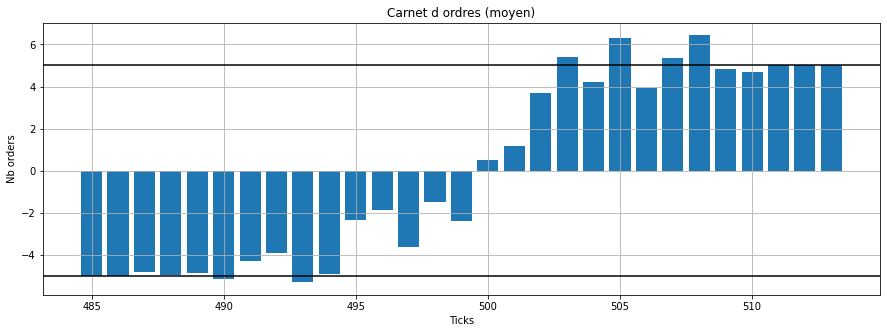

In [ ]:
t = 10
x = np.array(C.mean(axis=0).index.to_list())# - np.array(np.repeat(N/2,len(C.mean(axis = 0).index.to_list())))
y = C.mean(axis=0).to_list()
plt.figure(figsize=(15,5));
plt.bar(x,y);
plt.xlabel('Ticks');
plt.ylabel('Nb orders');
plt.axhline(-5,color='k')
plt.axhline(5,color='k')
plt.title(f'Carnet d ordres (moyen)');
plt.grid()

> En moyenne aux extrémités de la fenêtre glissante, le nombre d'ordres est en égal à 5 ce qui correspond à Q = $\frac{\lambda}{\delta}$.

> A t = 0, le nombre d'ordres est égal à 5 sur tous les ticks du côté bid et ask sur une fenêtre glissante de 10. Au fil du temps, la fenêtre va se déplacer dans le sens du prix au fur et à mesure que le spread s'écarte. 

> Sur le graphe ci dessus, on observe que les quantités disponibles sur les ticks proches des meilleurs bids et asks sont plus faibles dû à la prise de liquidité. Tandis que la quantité du nombre d'ordres sur les ticks éloignés est plus élevée car moins impactée par la prise de liquidité.

### Question b : Histogramme du spread 

## Tracé de l'evolution du spread et de son histogramme

On precise que le tick unitaire vaut 0.01;

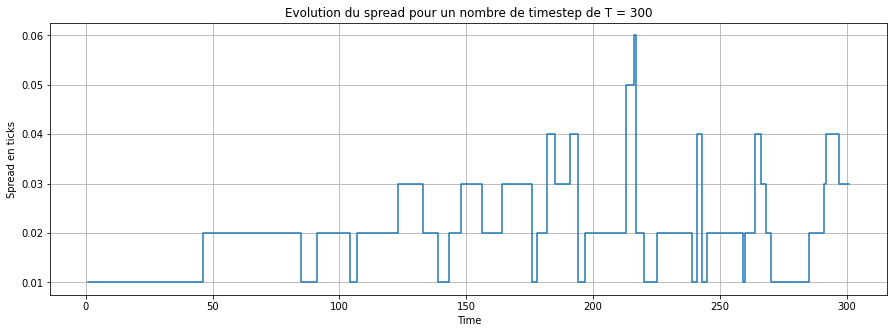

In [ ]:
plt.figure(figsize=(15,5));
plt.step(np.arange(1,len(CarnetA.list_spread)+1),CarnetA.list_spread);
plt.xlabel('Time');
plt.ylabel('Spread en ticks');
plt.title(f'Evolution du spread pour un nombre de timestep de T = {T}');
plt.grid()

> On voit bien que le spread est strictement positif.Durant les premiers instants le spread reste a son niveau initial.En effet le spread ne s'ecarte pas tant que toute la liquidité au meilleur prix ask ou bid n'a pas été consommée.

> D'autre part les variations brusques de spread sont dûes a l'introduction de liquidité dans le spread par l'intermediaire  d'ordres limites.On observe par exemple au temps evenementiel 240 une baisse soudaine du spread.Cet apport de liquidité s'accompagne d'une prise presque instantannée de liquidité au temps evenementiel 241.

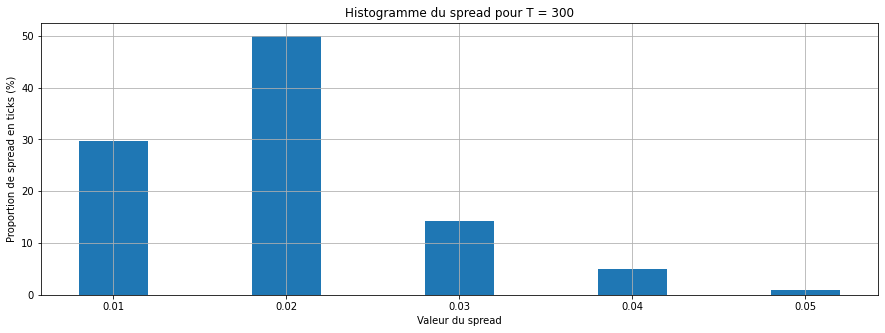

In [ ]:
plt.figure(figsize=(15,5));
plt.hist(np.round(CarnetA.list_spread,2),bins=[0.005,0.015,0.025,0.035,0.045,0.055],rwidth=0.4,density=True);
plt.xlabel('Valeur du spread');
plt.ylabel('Proportion de spread en ticks (%)');
plt.title(f'Histogramme du spread pour T = {T}');
plt.grid()

> La majeur partie des spreads sont a 0.02 soit 2 unitées de base .Une proportion du spread 0.01 est dûe à l'initialisation ou l'on consomme la liquidité au meilleur prix Bid et au meilleur prix Ask.  

### Question c : Tracé des prix 

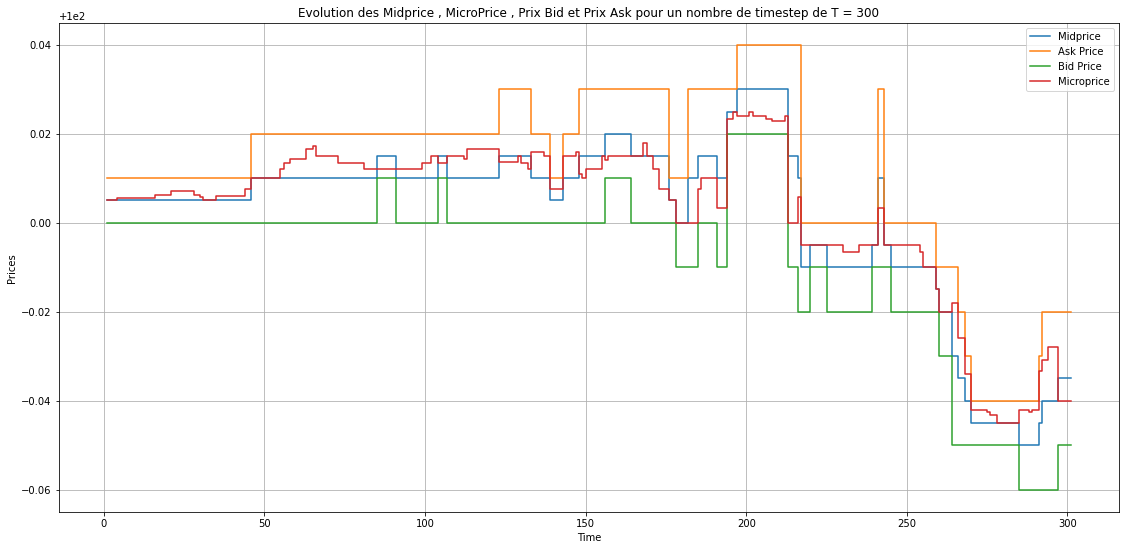

In [ ]:
plt.figure(figsize=(19,9));
plt.step(np.arange(1,len(CarnetA.midp)+1),np.round(CarnetA.midp,5),label = "Midprice");
plt.step(np.arange(1,len(CarnetA.pa)+1),np.round(CarnetA.pa,5),label = "Ask Price")
plt.step(np.arange(1,len(CarnetA.pb)+1),np.round(CarnetA.pb,5),label = "Bid Price")
plt.step(np.arange(1,len(CarnetA.microp)+1),CarnetA.microp,label = "Microprice") ### Probleme micro price à checker 
plt.legend()
plt.xlabel('Time');
plt.ylabel('Prices');
#plt.ylim(99.95,100.05)
plt.title(f'Evolution des Midprice , MicroPrice , Prix Bid et Prix Ask pour un nombre de timestep de T = {T}');
plt.grid()

>  Nous pouvons verifier graphiquement que le MidPrice est bien tout le temps la moyenne du Ask et du Bid. Il est également interessant de noter la fluctuation du MicroPrice autour du MidPrice.

The Micro-Price: A High Frequency Estimator of Future Prices.



In [ ]:
## Construction d un object carnet
T2  =  15000
CarnetB = CarnetOrdres(N = N,fix_seed = None, T = T2, W = W , lmbda = 1 ,mu = 5 , delta = 0.2, Q = 1, OB = OB)
CarnetB.Simulate()

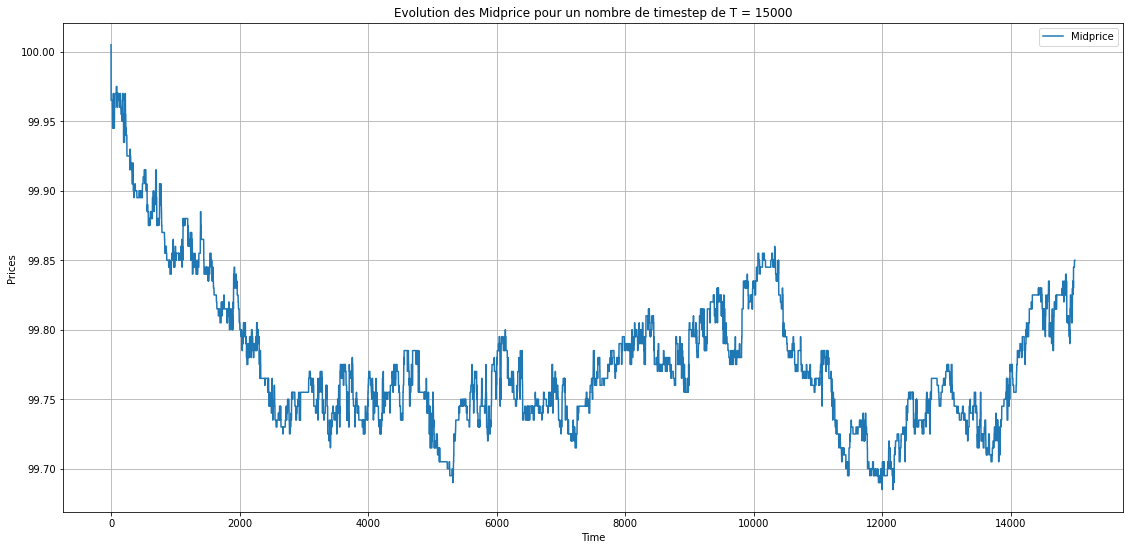

In [ ]:
plt.figure(figsize=(19,9));
plt.plot(CarnetB.midp,label = "Midprice");
plt.legend()
plt.xlabel('Time');
plt.ylabel('Prices');
plt.title(f'Evolution des Midprice pour un nombre de timestep de T = {T2}');
plt.grid()

> On note que le mouvemment du midPrice est cohérent avec la dynamique du carnet d'ordre obtenue précedement.

### Question d : Tracé de l'Histogramme des increments prix.

Test Jarque Bera : Note that this test only works for a large enough number of data samples (>2000) as the test statistic asymptotically has a Chi-squared distribution with 2 degrees of freedom.

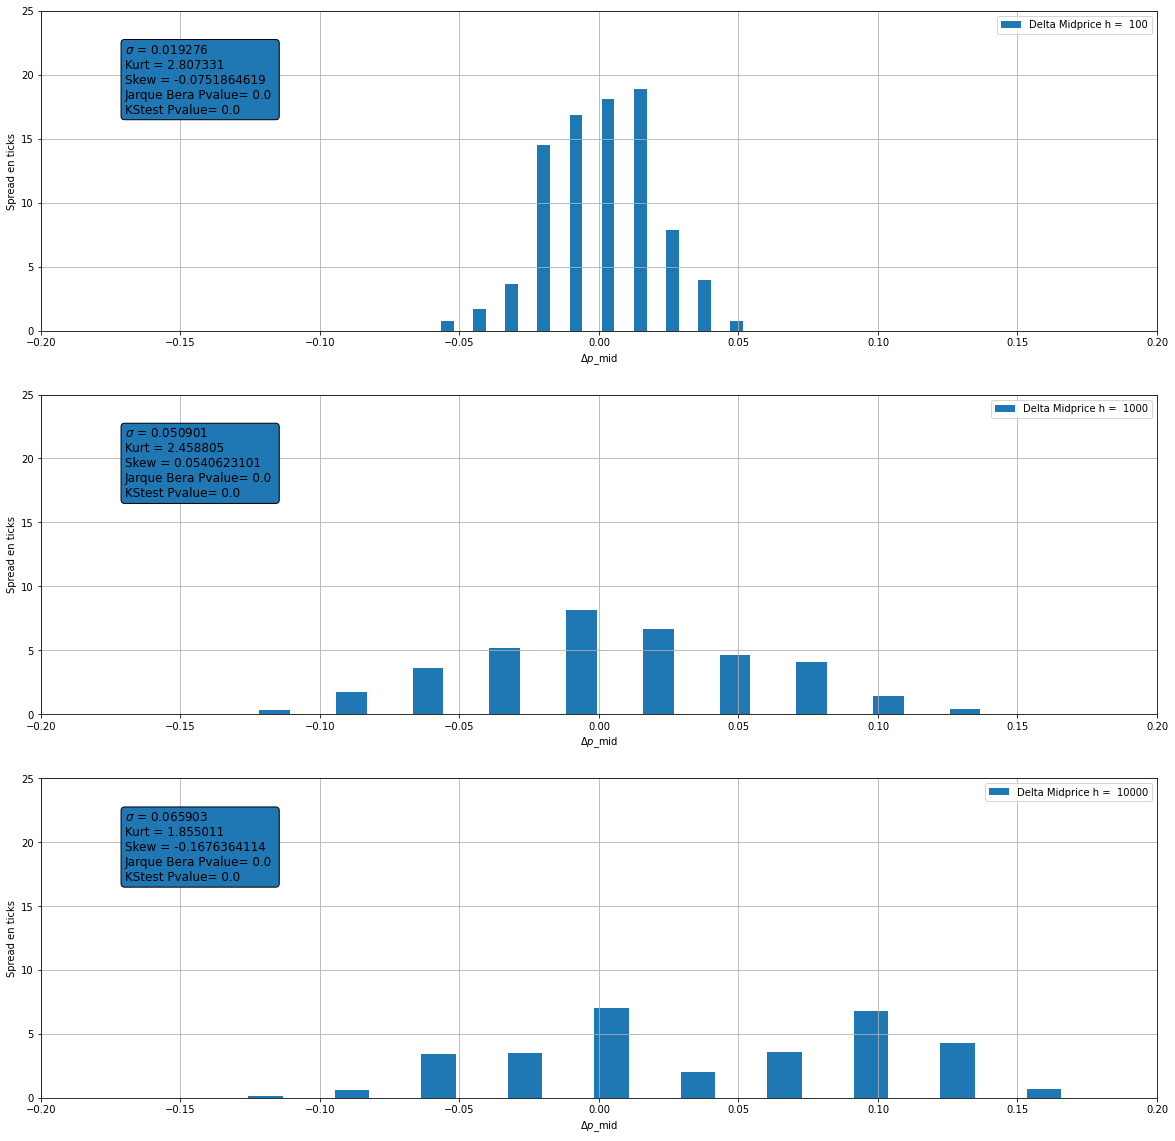

In [ ]:
from scipy.stats import  skew , kurtosis , jarque_bera , shapiro , kstest
import scipy.stats as stats
h = [100,1000,10000] ; 
fig , ax = plt.subplots(len(h),figsize=(20,20))
for i in range(len(h)):
  DeltaMid_Tab = pd.DataFrame() ; DeltaMid_Tab['Mid'] = CarnetB.midp ; DeltaMid_Tab['MidShift'] = CarnetB.midp 
  DeltaMid_Tab['MidShift'] = DeltaMid_Tab['MidShift'].shift(h[i]) ; DeltaMid_Tab = DeltaMid_Tab.dropna() 
  DPmid =   DeltaMid_Tab['MidShift'] - DeltaMid_Tab['Mid']
  ax[i].hist(DPmid.values, rwidth=0.4 , density=True , label = "Delta Midprice h =  " + str(h[i]))
  #stats.probplot(DPmid.values, dist="norm", plot = ax[i,1])
  ax[i].legend()
  ax[i].set_xlabel(f'$\Delta p$_mid');
  ax[i].set_ylabel('Spread en ticks');
  ax[i].set_xlim(-0.2,0.2)
  ax[i].set_ylim(0,25)
  JB = jarque_bera(DPmid.values)
  KS = kstest(DPmid.values,'norm')
  ax[i].text(-0.17,17,f"$\sigma$ = {np.round(np.std(DPmid.values),6)}  \nKurt = {np.round(kurtosis(DPmid.values,fisher=False),6)} \nSkew = {np.round(skew(DPmid.values),10)} \nJarque Bera Pvalue= {np.round(JB[1],6)} \nKStest Pvalue= {np.round(KS[1],6)}",fontsize=12,color = "black",bbox = dict(boxstyle="round"))
  ax[i].grid()

> A première vue, il semblerait que pour h = 100, l'histogramme du $\Delta p^{mid}$ soit proche d'une loi normale (kurtosis proche de 3 et skew proche de 0) puis que la distribution s'étale lorsque h augmente. En revanche lorsqu'on applique des tests de normalité, aucune des distributions suit réellemeent une loi normale au niveau de confiance de 95 %.

> On observe que la distribution s'étale quand h trés grand devant 1.

### e : Autocorrelation des increments $P^{mid},P^{micro},P^{trade}$

> On visualise le Trade Price pour $T = 300$ :

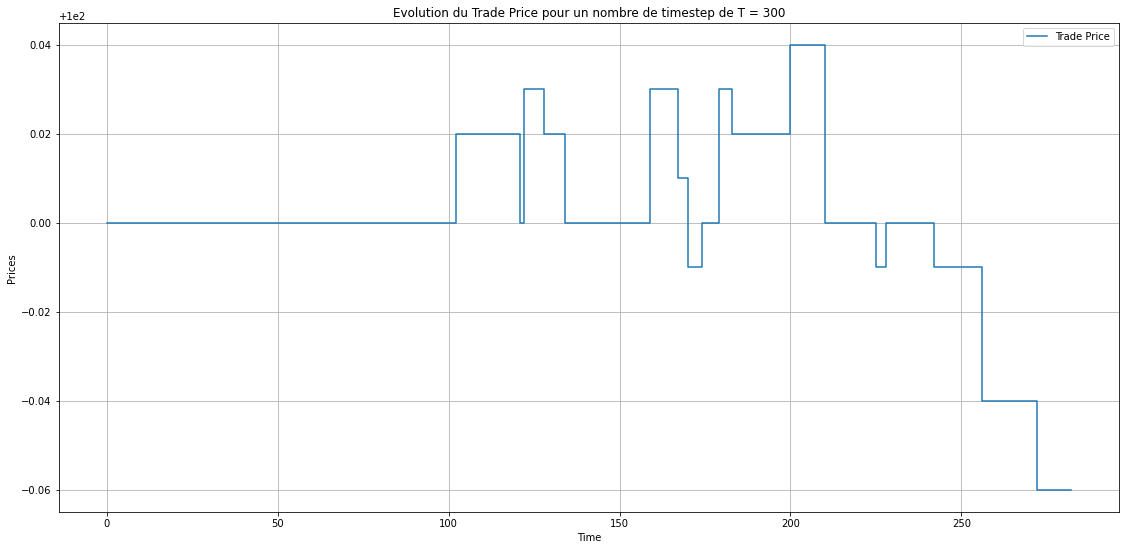

In [ ]:
plt.figure(figsize=(19,9));
plt.step(np.arange(0,len(CarnetA.tradep),1),CarnetA.tradep,label = "Trade Price");
plt.legend()
plt.xlabel('Time');
plt.ylabel('Prices');
plt.title(f'Evolution du Trade Price pour un nombre de timestep de T = {T}');
plt.grid()

[None,
 (0.01, 1),
 Text(0, 0.5, 'autocorrelation'),
 None,
 Text(0.5, 0, 'lag'),
 Text(0.5, 1.0, 'Partial Autocorrélation des Trade Prices')]

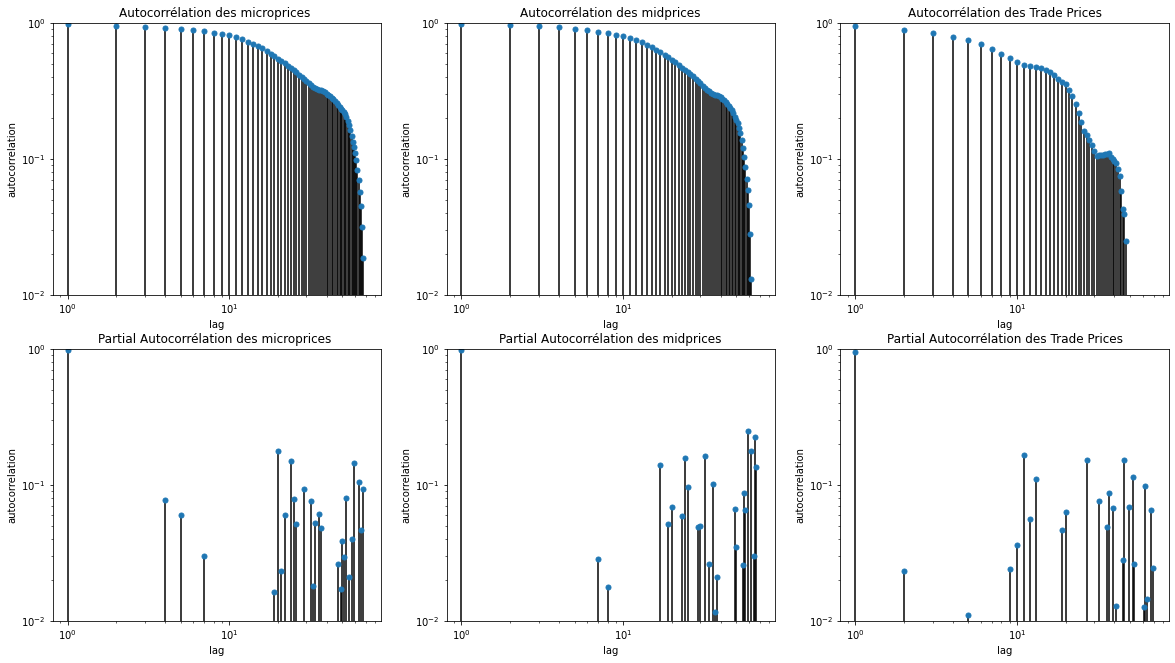

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
fig, ax = plt.subplots(2,3,figsize=(20,11))
lags = 70

plot_acf(CarnetA.microp,lags= lags, alpha=None, ax=ax[0,0]);
ax[0,0].set(title="Autocorrélation des microprices ", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))
plot_acf(CarnetA.midp,lags= lags , alpha=None, ax=ax[0,1]);
ax[0,1].set(title="Autocorrélation des midprices", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))
plot_acf(CarnetA.tradep,lags= lags , alpha=None, ax=ax[0,2]);
ax[0,2].set(title="Autocorrélation des Trade Prices", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))

plot_pacf(CarnetA.microp,lags= lags, alpha=None, ax=ax[1,0]);
ax[1,0].set(title="Partial Autocorrélation des microprices ", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))
plot_pacf(CarnetA.midp,lags= lags , alpha=None, ax=ax[1,1]);
ax[1,1].set(title="Partial Autocorrélation des midprices", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))
plot_pacf(CarnetA.tradep,lags= lags , alpha=None, ax=ax[1,2]);
ax[1,2].set(title="Partial Autocorrélation des Trade Prices", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))

[(0.01, 1.0),
 Text(0, 0.5, 'autocorrelation'),
 Text(0.5, 0, 'lag'),
 Text(0.5, 1.0, 'Partial Autocorrélation des Trade Prices')]

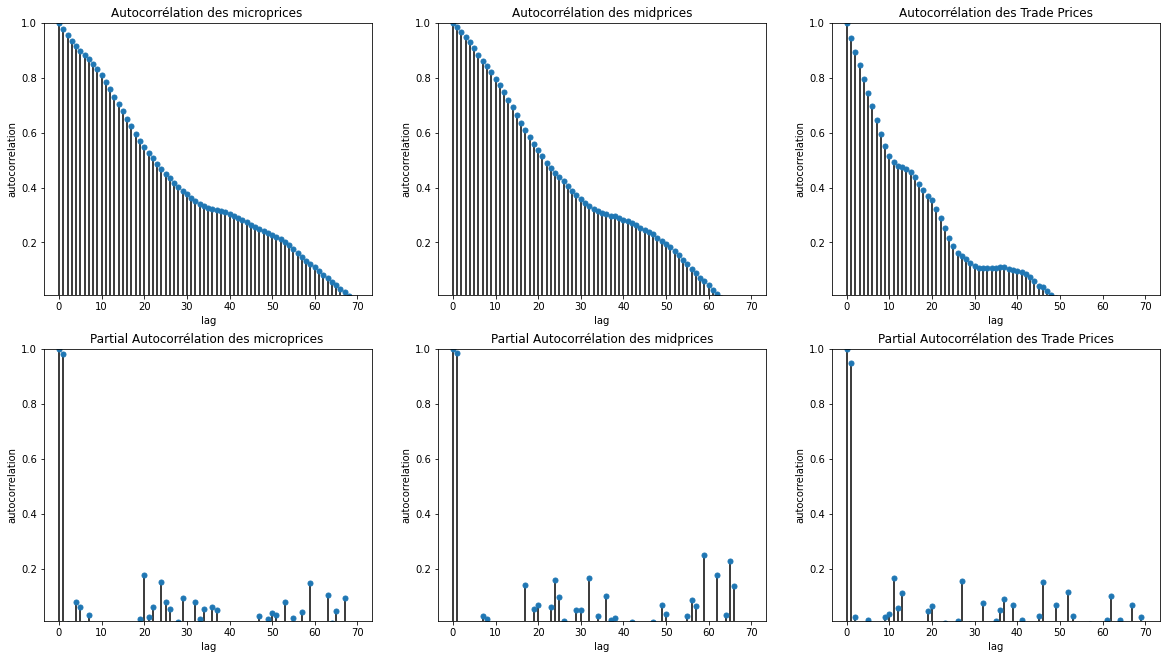

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
fig, ax = plt.subplots(2,3,figsize=(20,11))
lags = 70

plot_acf(CarnetA.microp,lags= lags, alpha=None, ax=ax[0,0]);
ax[0,0].set(title="Autocorrélation des microprices ", xlabel="lag", ylabel="autocorrelation", ylim=(10**-2,1))
plot_acf(CarnetA.midp,lags= lags , alpha=None, ax=ax[0,1]);
ax[0,1].set(title="Autocorrélation des midprices", xlabel="lag", ylabel="autocorrelation", ylim=(10**-2,1))
plot_acf(CarnetA.tradep,lags= lags , alpha=None, ax=ax[0,2]);
ax[0,2].set(title="Autocorrélation des Trade Prices", xlabel="lag", ylabel="autocorrelation", ylim=(10**-2,1))

plot_pacf(CarnetA.microp,lags= lags, alpha=None, ax=ax[1,0]);
ax[1,0].set(title="Partial Autocorrélation des microprices ", xlabel="lag", ylabel="autocorrelation", ylim=(10**-2,1))
plot_pacf(CarnetA.midp,lags= lags , alpha=None, ax=ax[1,1]);
ax[1,1].set(title="Partial Autocorrélation des midprices", xlabel="lag", ylabel="autocorrelation", ylim=(10**-2,1))
plot_pacf(CarnetA.tradep,lags= lags , alpha=None, ax=ax[1,2]);
ax[1,2].set(title="Partial Autocorrélation des Trade Prices", xlabel="lag", ylabel="autocorrelation", ylim=(10**-2,1))

> On observe immédiatement que les prix ne suivent pas une loi normale étant donné que les autocorrélations sont toujours supérieures en valeur absolue au seuil de la loi normale.

> L'autocorrelogramme nous permet également d'etudier si le processus est à courte ou longue mémoire.On observe que l'autocorrelation tend vers 0 plus rapidement qu'une loi exponetielle.Nous avons tracé le graphique d'autocorrelation en log-log pour verifier si il y la decroissance suvait une  loi de puissance ,c 'est a dire un processus à longue mémoire.Ce n'est pas le cas , on en deduit que les processus sont à courte mémoire.De plus l'autocorrelation partielle  nous indique que le seul lag significatif est h = 1.Il conforte donc les resultats enoncés précédements sur la courte mémoire.

### Question f : Variance du $\Delta p^{mid}(h)$

In [ ]:
h = np.arange(1,2000,1) ;
Var_tab = pd.DataFrame(columns=['variance_midp'])
for i in tqdm(range(len(h))):

  DeltaMid_Tab = pd.DataFrame() ; DeltaMid_Tab['Mid'] = CarnetB.midp ; DeltaMid_Tab['MidShift'] = CarnetB.midp 
  DeltaMid_Tab['MidShift'] = DeltaMid_Tab['MidShift'].shift(h[i]) ; DeltaMid_Tab = DeltaMid_Tab.dropna()
  Var_tab = Var_tab.append({'variance_midp' : np.var(DeltaMid_Tab['MidShift'] - DeltaMid_Tab['Mid'])}, ignore_index=True)

No handles with labels found to put in legend.


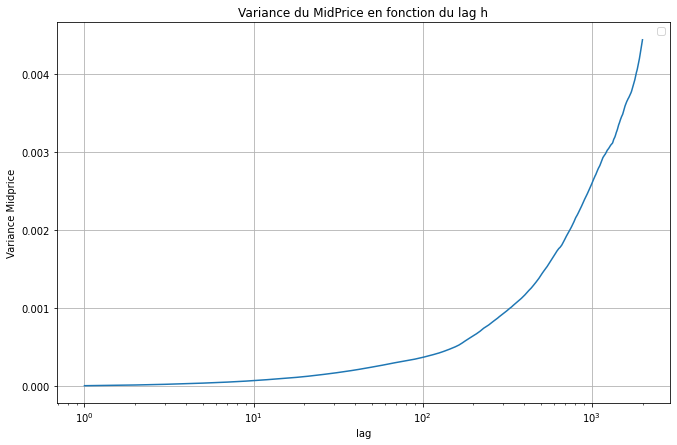

In [ ]:
fig , ax = plt.subplots(figsize=(11,7))
ax.plot(h,Var_tab['variance_midp'].values)
ax.legend()
ax.set_xlabel('lag');
ax.set_ylabel('Variance Midprice');
ax.set(xscale="log")
ax.set_title('Variance du MidPrice en fonction du lag h');
ax.grid()

> On observe que la variance augmente quand le lag augemente car le mouvemement du mid price est plus important pour des intervalles de temps événementiels grands.

## 3.3 : Question supplementaire

On relaxe l'hypothese d'une taille unitaire des ordres. On modifit l'algorithme precedent pour prendre en compte une taille d'ordres tirée aléatoirement selon une loi demi-normale.

En théorie des probabilités et en statistique, la loi demi-normale est un cas particulier de la loi normale repliée.

Soit ${\displaystyle X}$  une variable aléatoire de loi normale centrée, ${\displaystyle X\sim {\mathcal {N}}(0,\sigma ^{2})} $, alors ${\displaystyle Y=|X|}$ est de loi demi-normale. La loi demi-normale est une loi normale repliée de paramètre 0 et ${\displaystyle \sigma }$ .

La densité de probabilité de la loi demi-normale est donnée par :

- $ f_{Y}(y,\theta) = \frac{\sqrt{2}}{\sigma \sqrt{\pi}}exp(\frac{-y^2}{2\sigma^2})$  

- L'esperance est : $\mathbb {E} [Y]=\mu ={\frac {\sigma {\sqrt {2}}}{\sqrt {\pi }}}$.

- La variance est : ${\displaystyle \operatorname {Var} (Y)=\sigma^{2}\left(1-{\frac {2}{\pi }}\right).}$

In [ ]:
class CarnetOrdresQvar(object):
  """
      Modèle zéro-intelligence
  """
  def __init__(self,p0= 100,tick = 0.01,N = 1000,fix_seed = None, T = 10, W = 10 , lmbda = 1 ,mu = 5 , delta = 0.2, Q = 1, OB = None):
    self.N = N
    self.p0 = p0
    self.tick = tick
    self.T = T
    self.W = W
    self.orders = orders
    self.OB = OB
    self.list_spread = list() ; self.histo_ordres = list() ;
    self.midp = list() ; self.microp = list() ; self.tradep = list() ; 
    self.Q = Q ; self.Qa = list() ; self.Qb = list() ; 
    self.a0 = self.p0 + self.tick ; self.b0 = self.p0
    self.pa = list() ; self.pb = list() ; 
    self.lmbda = lmbda ; self.mu = mu ; self.delta = delta ; 
    self.fix_seed = fix_seed
    self.carnet = pd.DataFrame()

    if self.fix_seed: 
      # On Initialise un graine pour fixer la sequence d'ordres futures au cour des t de 0 à T
      np.random.seed(fix_seed)
      self.list_seed = np.random.uniform(low=100,high=20000,size = T)

  def midprice(self):
      return (self.pa[-1]+self.pb[-1])/2

  def microprice(self):
      return ((self.Qb[-1]*self.pa[-1] + self.Qa[-1]*self.pb[-1])/(self.Qa[-1]+self.Qb[-1]))

  def spread(self):
      return self.pa[-1]-self.pb[-1]

  def probas_intervals(self,probas,orders,Na,Nb):

    normalized_prob = np.cumsum(probas)/np.sum(probas)
    iv = {} ; iv[str(orders[0])] = pd.Interval(left=0, right=normalized_prob[0])
    for i in range(1,len(normalized_prob)):
      iv[str(orders[i])] = pd.Interval(left=normalized_prob[i-1], right=normalized_prob[i])
    return iv

  def FindOrder(self,radom_val,orders,iv):
    for i in range(len(orders)):
      if radom_val in iv[str(orders[i])]:
        return orders[i]
  
  def Simulate(self):

    carnet = pd.DataFrame()
    index_ask = int(N/2) ; index_bid = int(N/2)-1  ;
    list_ind_ask = [index_ask] ; list_ind_bid = [index_bid]
    self.pa.append(self.a0) ; self.pb.append(self.b0)
    self.midp.append(self.midprice()) ; self.list_spread.append(self.spread())
    self.Qa.append(np.int(np.abs(self.OB[index_ask]))) ; self.Qb.append(np.int(np.abs(self.OB[index_bid])))
    self.microp.append(self.microprice()) ; last_transaction = self.p0

    for i in tqdm(range(self.T)):
      #print(i)

      ## Calcul le nombre d ordres du cote bid et ask
      Na = np.int(np.sum(self.OB[index_ask:(index_ask + self.W)])) ; Nb = np.int(np.sum(self.OB[(index_bid - self.W):index_bid]))
      probas = [self.mu/2,self.mu/2,self.W*self.lmbda,self.W*self.lmbda,self.delta*np.abs(Na),self.delta*np.abs(Nb)]
      Interv = self.probas_intervals(probas,orders,Na,Nb) ## Retourne les intervales pour chaque ordre 
      #print(f"L intervalle pour l iteration {i} est : {Interv}")
      Random_Choice = np.random.uniform(low = 0, high = 1) ## v.a unif entre 0 et 1 
      new_order = self.FindOrder(Random_Choice,orders,Interv) ## Retourne l ordre choisit aleatoirement

      iloc = np.random.randint(low = 1, high = self.W) ## v.a unif entre 1 et W pour choisir a quelle niveau de prix l ordre est passé
      #print(new_order)
      self.histo_ordres.append(new_order)

      order_size = int(np.abs(np.random.normal(loc=0,scale=(3.14/(np.sqrt(2*(3.14-2))))*1e3)))
      if new_order ==  "Ls" : ## Limit order a la vente
      # on prend le iloc ieme tick a droite de la meilleur offre bid 
        self.OB[index_bid + iloc] = self.OB[index_bid + iloc] + order_size
        self.tradep.append(last_transaction)

      elif new_order ==  "Lb" : ## Limit order a l'achat
      # on prend le iloc ieme tick a gauche de la meilleur offre ask
        self.OB[index_ask - iloc] = self.OB[index_ask - iloc] - order_size
        self.tradep.append(last_transaction)

      elif new_order == "Cb": ## Cancel order a l'achat
      # on prend le iloc ieme tick a gauche de la meilleur offre ask
        if self.OB[index_ask - iloc] < 0 :
          self.OB[index_ask - iloc] = int(self.OB[index_ask - iloc] + delta*np.abs(self.OB[index_ask - iloc]))
          self.tradep.append(last_transaction)

      elif new_order == "Cs": ## Cancel order a la vente
      # on prend le iloc ieme tick a droite de la meilleur offre bid
        if self.OB[index_bid + iloc] > 0 :
          self.OB[index_bid + iloc] = int(self.OB[index_bid + iloc] - delta*np.abs(self.OB[index_bid + iloc]))
          self.tradep.append(last_transaction)

      elif new_order ==  "Ms" : ## Market order a la vente
      # on consomme directement la liquidité au meilleur prix ask
        if  np.abs(self.OB[index_bid]) > order_size:
          self.OB[index_bid] = self.OB[index_bid] + order_size
        elif np.abs(self.OB[index_bid]) <= order_size:
          self.OB[index_bid] = 0

        self.tradep.append(self.pa[-1]) ; last_transaction = self.pa[-1]
        
      elif new_order ==  "Mb" : ## Market order a l'achat
      # on consomme directement la liquidité au meilleur prix bid
        if  np.abs(self.OB[index_ask]) > order_size:
          self.OB[index_ask] = self.OB[index_ask] - order_size
        if  np.abs(self.OB[index_ask]) <= order_size:
          self.OB[index_ask] = 0 

        self.tradep.append(self.pb[-1]) ; last_transaction = self.pb[-1]
      

        
      index_ask = np.min(np.where(np.array(self.OB) > 0)[0]) ; list_ind_ask.append(index_ask) ; self.pa.append(self.pa[-1] + self.tick*(list_ind_ask[-1] - list_ind_ask[-2]));
      index_bid = np.max(np.where(np.array(self.OB) < 0)[0]) ; list_ind_bid.append(index_bid) ; self.pb.append(self.pb[-1] + self.tick*(list_ind_bid[-1] - list_ind_bid[-2]));

      
      self.Qa.append(np.abs(self.OB[index_ask])) ; self.Qb.append(np.abs(self.OB[index_bid])) ; self.list_spread.append(self.spread())
      self.midp.append(self.midprice()) ; self.microp.append(self.microprice())

      self.carnet = self.carnet.append(pd.DataFrame([self.OB]), ignore_index = True)


> On prend un vecteur initial de 2000 pour le $OB$ pour compenser le paramètre d'échelle de la loi demi-normale qui est très grand.

In [ ]:
N = 1000  # vecteur OB de taille finie N
lmbda = 2 ; mu = 10 ; delta = 0.001 ; T = 200 ; W = 10  ; Q = 1 # intensités des proc poisson et T horizon du carnet d'ordre
OB = int(N/2)*[-2000] + int(N/2)*[2000]  # Initialisation du vecteur OB , valeurs arbitraires
tick = 0.01 ;p0 = 100;
orders = ["Ms","Mb","Lb","Ls","Cs","Cb"]

In [ ]:
## Construction d un object carnet
CarnetC = CarnetOrdresQvar(p0 = p0,N = N,fix_seed = None, T = T, W = W , lmbda = lmbda , mu = mu , delta = delta, Q = 1, OB = OB)
CarnetC.Simulate()
Historique = CarnetC.histo_ordres
Cbis = CarnetC.carnet.iloc[:, int(N/2-W-5):int(N/2+W+4)]
Historique = CarnetC.histo_ordres

In [ ]:
%%capture
from celluloid import Camera # getting the camera
from IPython.display import HTML # to show the animation in Jupyter

cdict = {1: 'blue', 2: 'red' , 3: "white"}
labels = ["bid","ask","spread"] 

fig, ax = plt.subplots(figsize = (15,8))
camera = Camera(fig)# the camera gets the fig we'll plot
for t in tqdm(range(0,T,1)):
  x = Cbis.iloc[t,:].index.values# - np.array(np.repeat(N/2,len(C.mean(axis = 0).index.to_list())))
  y = Cbis.iloc[t,:].values
  if len(np.where(np.array(y) == 0)[0]) == 0:
    cblue = np.where(np.array(y) < 0)[0] ; cred = np.where(np.array(y) > 0)[0]
    color = np.zeros(x.shape[0]) ; color[cblue] = 1 ; color[cred] = 2
  else:
    cblue = np.where(np.array(y) < 0)[0] ; cred = np.where(np.array(y) > 0)[0] ; cempty = np.where(np.array(y) == 0)[0]
    color =np.zeros(x.shape[0]) ; color[cblue] = 1 ; color[cred] = 2 ; color[cempty] = 3
  for c in np.unique(color):
      ix = np.where(color == c)[0]
      ax.bar(x[ix],y[ix],color = cdict[int(c)])#,label = labels[int(c)-1])
  ax.set(title = f"Evolution du carnet d ordre",xlabel= "index  window",ylabel="Nb_ordres")
  ax.text(0.8,1.01,f"t = {t}",transform = ax.transAxes)
  if Historique[t].endswith("s"):
    ax.text(0.2,0.95,f"Order = {Historique[t]}",transform = ax.transAxes,fontsize=12,bbox = dict(boxstyle="round",facecolor = "red"),color = "white")
  else:
    ax.text(0.2,0.95,f"Order = {Historique[t]}",transform = ax.transAxes,fontsize=12,bbox = dict(boxstyle="round",facecolor = "blue"),color = "white")
  camera.snap() ; # the camera takes a snapshot of the plot
ax.legend();
ax.grid();

In [ ]:
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [ ]:
Q = lmbda/delta ; print(f"le nombre Q d'actions aux prix eloignes de l'ask et du bid est {Q}")

le nombre Q d'actions aux prix eloignes de l'ask et du bid est 2000.0


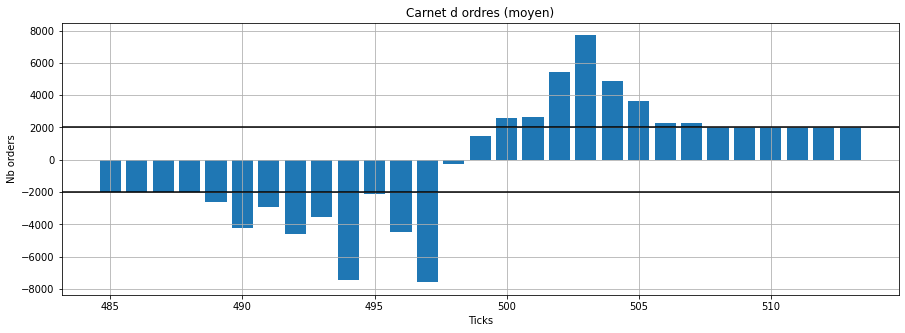

In [ ]:
t = 10
x = np.array(Cbis.mean(axis=0).index.to_list())# - np.array(np.repeat(N/2,len(C.mean(axis = 0).index.to_list())))
y = Cbis.mean(axis=0).to_list()
plt.figure(figsize=(15,5));
plt.bar(x,y);
plt.xlabel('Ticks');
plt.ylabel('Nb orders');
plt.axhline(-Q,color='k')
plt.axhline(Q,color='k')
plt.title(f'Carnet d ordres (moyen)');
plt.grid()

> On note que les quantités respectent bien le critére aux extrémités de la fenêtre glissante.

## Evolution du Spread:

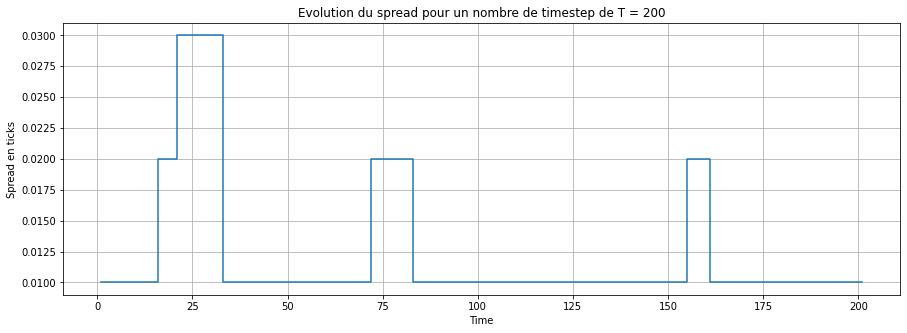

In [ ]:
plt.figure(figsize=(15,5));
plt.step(np.arange(1,len(CarnetC.list_spread)+1),CarnetC.list_spread);
plt.xlabel('Time');
plt.ylabel('Spread en ticks');
plt.title(f'Evolution du spread pour un nombre de timestep de T = {T}');
plt.grid()

> On voit que le spread varie moins que dans le cas ou la quantité par ordre est unitaire.Lorsqu'un ordre limite arrive dans le spread , une quantité importante permet de conserver un spread plus serré plus longtemps. En effet dans le cas ou nous avions une quantité unitaire par ordre , toute la liquidité était presque immediatement consommée.

## Histogramme du spread

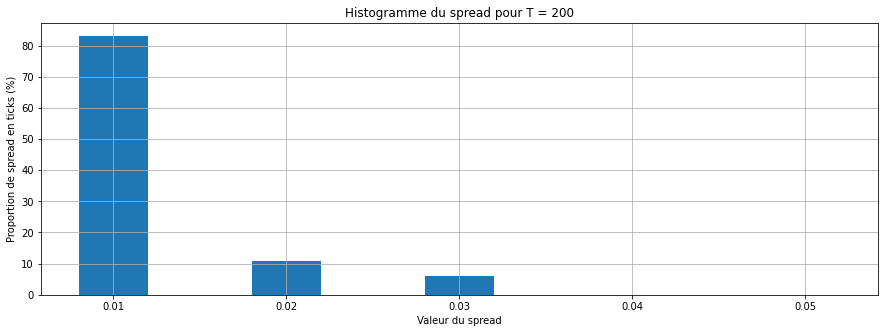

In [ ]:
plt.figure(figsize=(15,5));
plt.hist(np.round(CarnetC.list_spread,2),bins=[0.005,0.015,0.025,0.035,0.045,0.055],rwidth=0.4,density=True);
plt.xlabel('Valeur du spread');
plt.ylabel('Proportion de spread en ticks (%)');
plt.title(f'Histogramme du spread pour T = {T}');
plt.grid()

> On note bien sur l'histogramme que le Bid Ask spread reste à 0.01 dans plus de 80% des cas.C'est coherent avec la courbe d'evolution du spread affiché précédemment.(NB: l'unité du tick est 0.01)

## Evolution des Midprice , MicroPrice , Prix Bid et Prix Ask pour un nombre de timestep de T = 200

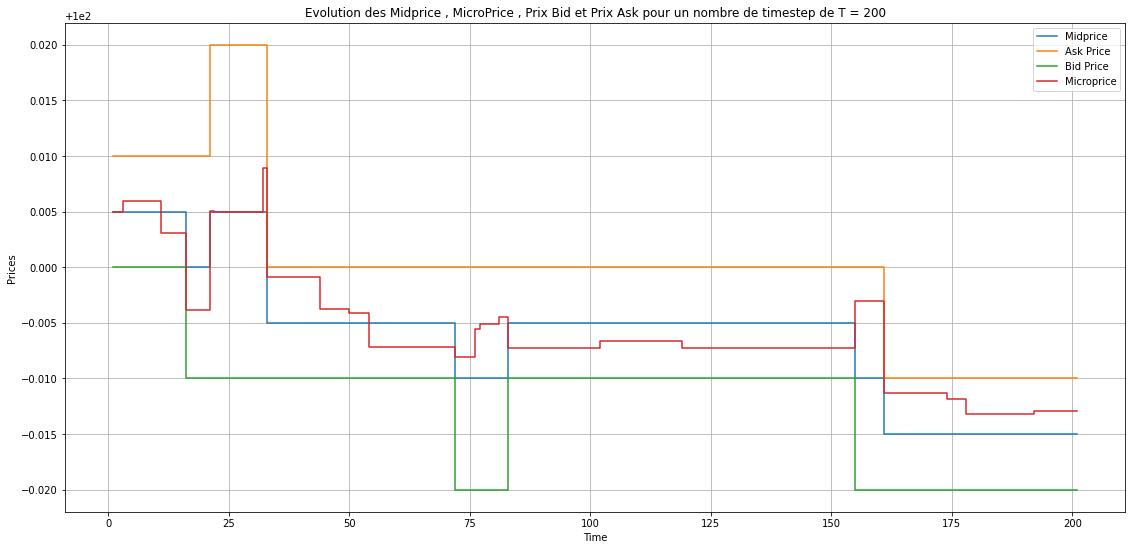

In [ ]:
plt.figure(figsize=(19,9));
plt.step(np.arange(1,len(CarnetC.midp)+1),np.round(CarnetC.midp,5),label = "Midprice");
plt.step(np.arange(1,len(CarnetC.pa)+1),np.round(CarnetC.pa,5),label = "Ask Price")
plt.step(np.arange(1,len(CarnetC.pb)+1),np.round(CarnetC.pb,5),label = "Bid Price")
plt.step(np.arange(1,len(CarnetC.microp)+1),CarnetC.microp,label = "Microprice") ### Probleme micro price à checker 
plt.legend()
plt.xlabel('Time');
plt.ylabel('Prices');
#plt.ylim(99.95,100.05)
plt.title(f'Evolution des Midprice , MicroPrice , Prix Bid et Prix Ask pour un nombre de timestep de T = {T}');
plt.grid()

## Evolution du MidPrice

In [ ]:
## Construction d un object carnet
T2  =  15000
CarnetBbis = CarnetOrdresQvar(N = N,fix_seed = None, T = T2, W = W , lmbda = lmbda ,mu = mu , delta = delta, Q = 1, OB = OB)
CarnetBbis.Simulate()

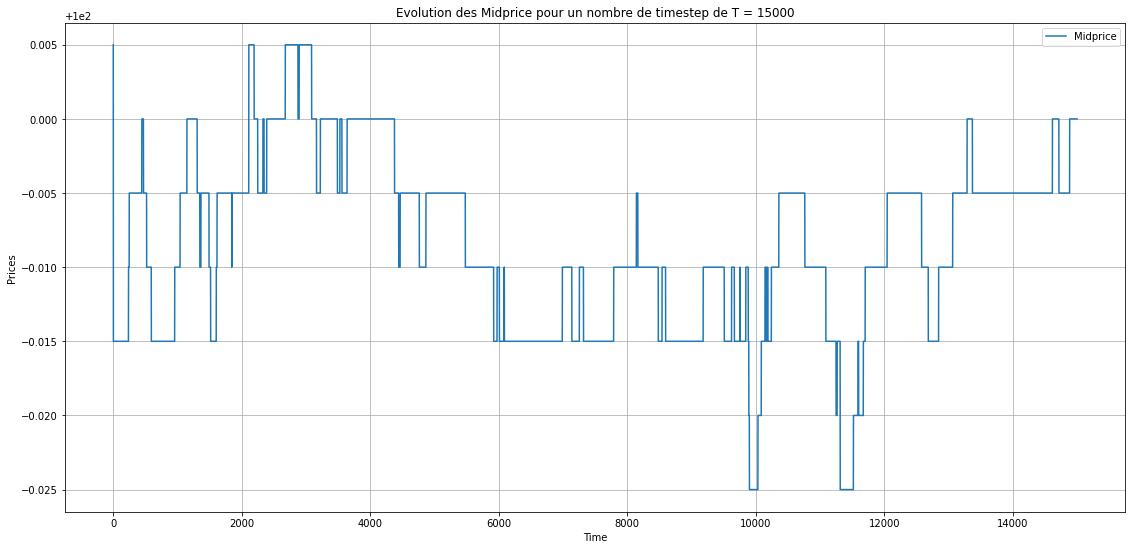

In [ ]:
plt.figure(figsize=(19,9));
plt.plot(CarnetBbis.midp,label = "Midprice");
plt.legend()
plt.xlabel('Time');
plt.ylabel('Prices');
plt.title(f'Evolution des Midprice pour un nombre de timestep de T = {T2}');
plt.grid()

## Histogramme du Midprice pour des lags h : 100 , 1000 & 10000

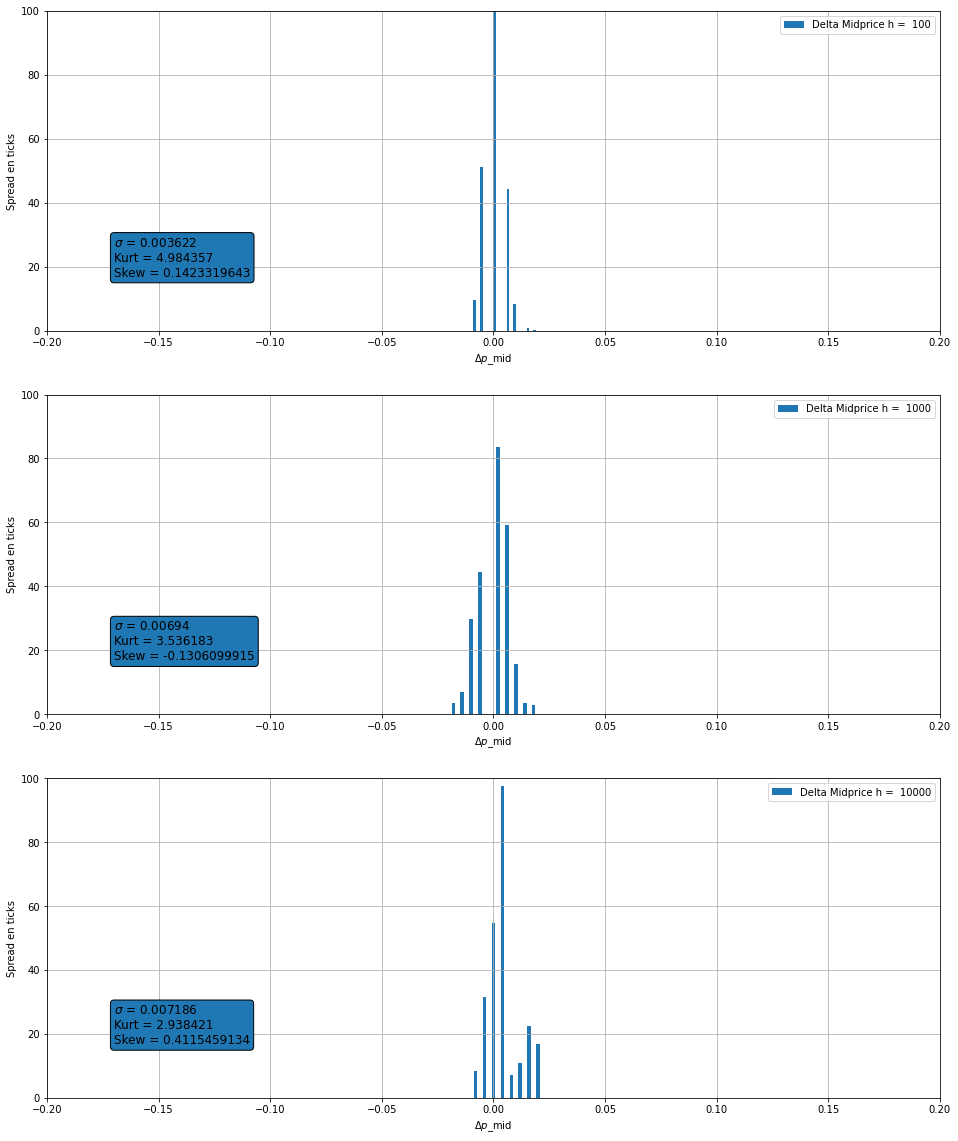

In [ ]:
from scipy.stats import  skew , kurtosis , jarque_bera
h = [100,1000,10000] ; 
fig , ax = plt.subplots(len(h),figsize=(16,20))
for i in range(len(h)):
  DeltaMid_Tab = pd.DataFrame() ; DeltaMid_Tab['Mid'] = CarnetBbis.midp ; DeltaMid_Tab['MidShift'] = CarnetBbis.midp 
  DeltaMid_Tab['MidShift'] = DeltaMid_Tab['MidShift'].shift(h[i]) ; DeltaMid_Tab = DeltaMid_Tab.dropna() 
  DPmid =   DeltaMid_Tab['MidShift'] - DeltaMid_Tab['Mid']
  ax[i].hist(DPmid.values, rwidth=0.4 , density=True , label = "Delta Midprice h =  " + str(h[i]))
  ax[i].legend()
  ax[i].set_xlabel(f'$\Delta p$_mid');
  ax[i].set_ylabel('Spread en ticks');
  ax[i].set_xlim(-0.2,0.2)
  ax[i].set_ylim(0,100)
  JB = jarque_bera(DPmid.values)
  ax[i].text(-0.17,17,f"$\sigma$ = {np.round(np.std(DPmid.values),6)}  \nKurt = {np.round(kurtosis(DPmid.values,fisher=False),6)} \nSkew = {np.round(skew(DPmid.values),10)}",fontsize=12,color = "black",bbox = dict(boxstyle="round"))
  ax[i].grid()

> La distribution n'est clairement pas gaussienne quelque soit la valeur de h.L'augmentation de l'écart type lorsque $h$ augmente est beaucoup moins important que dans le cas précédent.

## Evolution du Trade Price

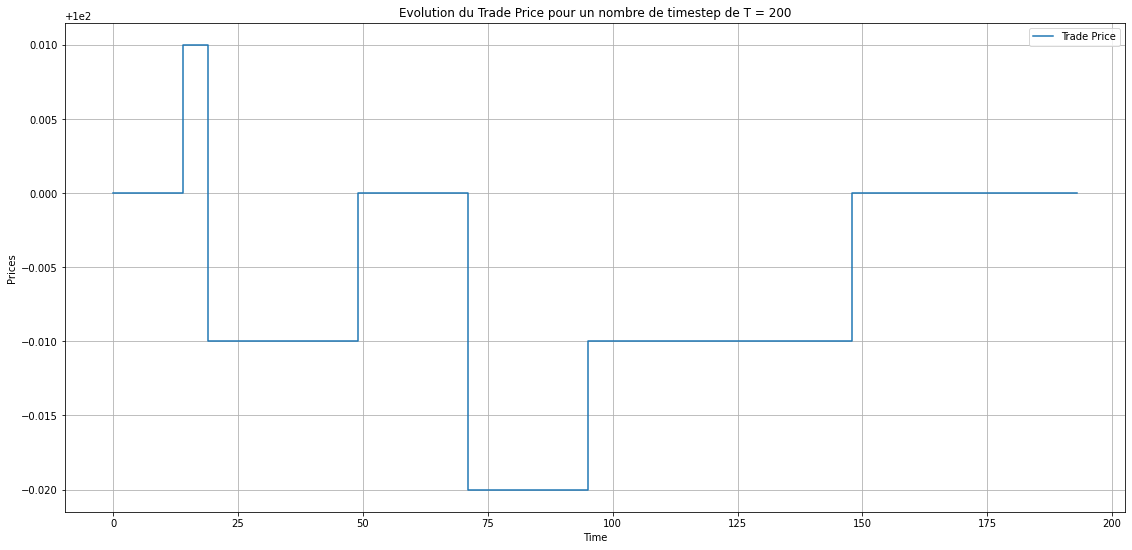

In [ ]:
plt.figure(figsize=(19,9));
plt.step(np.arange(0,len(CarnetC.tradep),1),CarnetC.tradep,label = "Trade Price");
plt.legend()
plt.xlabel('Time');
plt.ylabel('Prices');
plt.title(f'Evolution du Trade Price pour un nombre de timestep de T = {T}');
plt.grid()

## Autocorrelation des Micro , Mid et Trade Price

[None,
 (0.01, 1),
 Text(0, 0.5, 'autocorrelation'),
 None,
 Text(0.5, 0, 'lag'),
 Text(0.5, 1.0, 'Partial Autocorrélation des Trade Prices')]

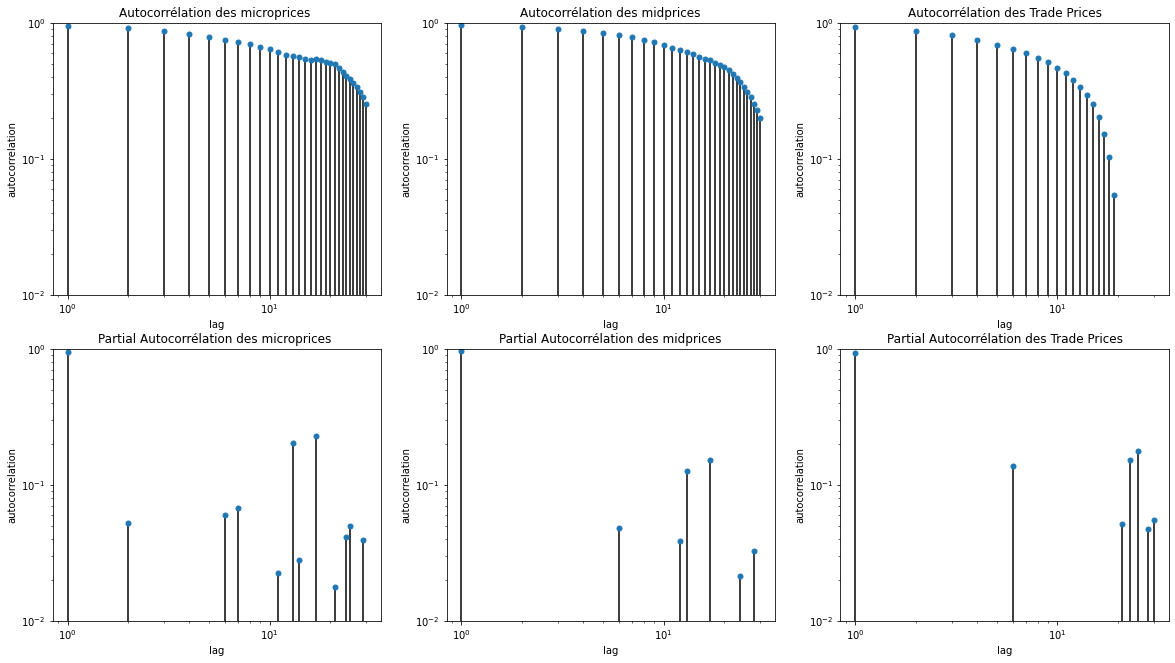

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
fig, ax = plt.subplots(2,3,figsize=(20,11))
lags = 30

plot_acf(CarnetC.microp,lags= lags, alpha=None, ax=ax[0,0]);
ax[0,0].set(title="Autocorrélation des microprices ", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))
plot_acf(CarnetC.midp,lags= lags , alpha=None, ax=ax[0,1]);
ax[0,1].set(title="Autocorrélation des midprices", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))
plot_acf(CarnetC.tradep,lags= lags , alpha=None, ax=ax[0,2]);
ax[0,2].set(title="Autocorrélation des Trade Prices", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))

plot_pacf(CarnetC.microp,lags= lags, alpha=None, ax=ax[1,0]);
ax[1,0].set(title="Partial Autocorrélation des microprices ", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))
plot_pacf(CarnetC.midp,lags= lags , alpha=None, ax=ax[1,1]);
ax[1,1].set(title="Partial Autocorrélation des midprices", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))
plot_pacf(CarnetC.tradep,lags= lags , alpha=None, ax=ax[1,2]);
ax[1,2].set(title="Partial Autocorrélation des Trade Prices", xlabel="lag", ylabel="autocorrelation", xscale="log", yscale="log", ylim=(10**-2,1))

[(0.01, 1.0),
 Text(0, 0.5, 'autocorrelation'),
 Text(0.5, 0, 'lag'),
 Text(0.5, 1.0, 'Partial Autocorrélation des Trade Prices')]

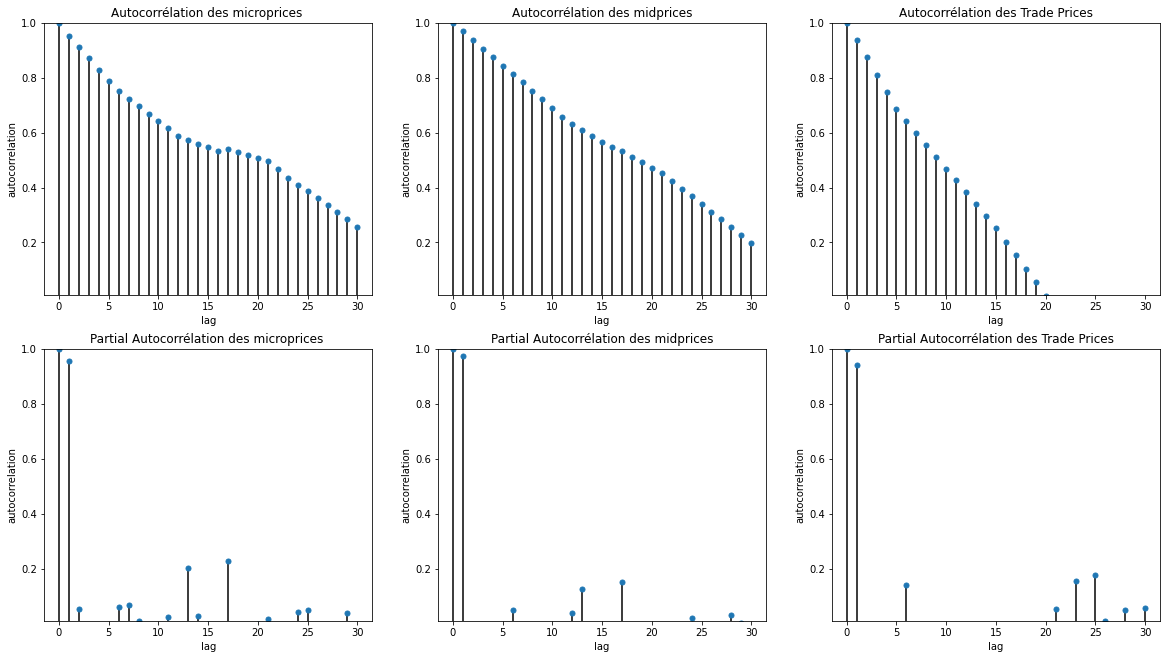

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
fig, ax = plt.subplots(2,3,figsize=(20,11))
lags = 30

plot_acf(CarnetC.microp,lags= lags, alpha=None, ax=ax[0,0]);
ax[0,0].set(title="Autocorrélation des microprices ", xlabel="lag", ylabel="autocorrelation", ylim=(10**-2,1))
plot_acf(CarnetC.midp,lags= lags , alpha=None, ax=ax[0,1]);
ax[0,1].set(title="Autocorrélation des midprices", xlabel="lag", ylabel="autocorrelation", ylim=(10**-2,1))
plot_acf(CarnetC.tradep,lags= lags , alpha=None, ax=ax[0,2]);
ax[0,2].set(title="Autocorrélation des Trade Prices", xlabel="lag", ylabel="autocorrelation", ylim=(10**-2,1))

plot_pacf(CarnetC.microp,lags= lags, alpha=None, ax=ax[1,0]);
ax[1,0].set(title="Partial Autocorrélation des microprices ", xlabel="lag", ylabel="autocorrelation", ylim=(10**-2,1))
plot_pacf(CarnetC.midp,lags= lags , alpha=None, ax=ax[1,1]);
ax[1,1].set(title="Partial Autocorrélation des midprices", xlabel="lag", ylabel="autocorrelation", ylim=(10**-2,1))
plot_pacf(CarnetC.tradep,lags= lags , alpha=None, ax=ax[1,2]);
ax[1,2].set(title="Partial Autocorrélation des Trade Prices", xlabel="lag", ylabel="autocorrelation", ylim=(10**-2,1))

> Avec les mêmes arguments que précédemment on déduit que les processus sont à courte mémoire.

## Variance des increments de prix

In [ ]:
h = np.arange(1,2000,1) ;
Var_tab = pd.DataFrame(columns=['variance_midp'])
for i in tqdm(range(len(h))):

  DeltaMid_Tab = pd.DataFrame() ; DeltaMid_Tab['Mid'] = CarnetBbis.midp ; DeltaMid_Tab['MidShift'] = CarnetBbis.midp 
  DeltaMid_Tab['MidShift'] = DeltaMid_Tab['MidShift'].shift(h[i]) ; DeltaMid_Tab = DeltaMid_Tab.dropna()
  Var_tab = Var_tab.append({'variance_midp' : np.var(DeltaMid_Tab['MidShift']- DeltaMid_Tab['Mid'])}, ignore_index=True) 


No handles with labels found to put in legend.


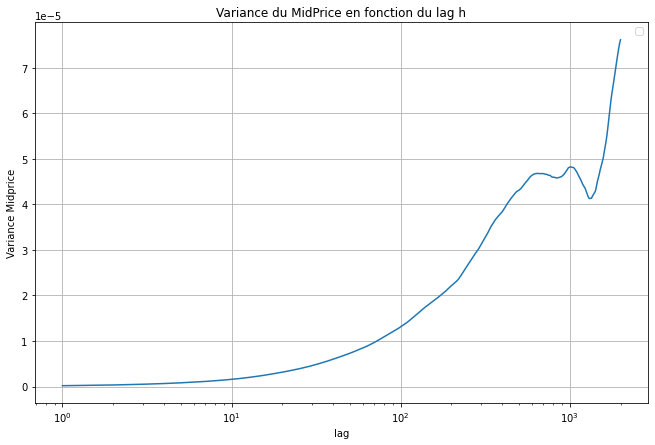

In [ ]:
fig , ax = plt.subplots(figsize=(11,7))
ax.plot(h,Var_tab['variance_midp'].values)
ax.legend()
ax.set_xlabel('lag');
ax.set_ylabel('Variance Midprice');
ax.set(xscale="log")
ax.set_title('Variance du MidPrice en fonction du lag h');
ax.grid()

> On voit que la variance augmente en moyenne avec la taille du lag.Contrairement au cas précédent , le spread et le midprice restent trés proches du midprice initial.En effet, le choix de quantités unitaires pour les ordres implique des variations de spread plus importantes et fréquentes.De plus ces variations ont pour effet de faire bouger plus rapidement le midprice contrairement au cas où le spread reste plus stable. 

> On observe bien que l'ordre de grandeur de la variance est de 1e-5 contrairement au 1e-3 obtenu précédement.